In [152]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/3rd-ml100marathon-midterm/train_data.csv
/kaggle/input/3rd-ml100marathon-midterm/test_features.csv
/kaggle/input/3rd-ml100marathon-midterm/sample_submission.csv
/kaggle/input/3rd-ml100marathon-midterm/enron61702insiderpay.pdf


In [153]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics, datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_curve
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor 
from mlxtend.classifier import StackingClassifier


data_path = '/kaggle/input/3rd-ml100marathon-midterm/'
df_train = pd.read_csv(data_path + 'train_data.csv')

df_test = pd.read_csv(data_path + 'test_features.csv')

df_train.head()

train_Y = df_train['poi'].astype('int')
ids = df_test['name']
df_train = df_train.drop(['name', 'poi', 'email_address'] , axis=1)
df_test = df_test.drop(['name','email_address'] , axis=1)
df = pd.concat([df_train, df_test])

df.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [154]:
df.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,8.200000e+01,3.900000e+01,4.900000e+01,1.700000e+01,1.020000e+02,9.500000e+01,86.000000,86.000000,86.000000,4.000000e+00,6.600000e+01,9.300000e+01,1.100000e+02,1.800000e+01,9.500000e+01,86.000000,86.000000,1.250000e+02,1.260000e+02
mean,2.374235e+06,1.642674e+06,-1.140475e+06,1.668049e+05,5.987054e+06,1.087289e+05,608.790698,64.895349,41.232558,4.196250e+07,1.470361e+06,9.190650e+05,2.321741e+06,1.664106e+05,5.621943e+05,1176.465116,2073.860465,5.081526e+06,6.773957e+06
std,1.071333e+07,5.161930e+06,4.025406e+06,3.198914e+05,3.106201e+07,5.335348e+05,1841.033949,86.979244,100.073111,4.708321e+07,5.942759e+06,4.589253e+06,1.251828e+07,4.201494e+06,2.716369e+06,1178.317641,2582.700981,2.906172e+07,3.895777e+07
min,7.000000e+04,-1.025000e+05,-2.799289e+07,3.285000e+03,3.285000e+03,1.480000e+02,12.000000,0.000000,0.000000,4.000000e+05,6.922300e+04,2.000000e+00,-2.604490e+06,-7.576788e+06,4.770000e+02,2.000000,57.000000,1.480000e+02,-4.409300e+04
25%,4.312500e+05,8.157300e+04,-6.948620e+05,9.878400e+04,5.278862e+05,2.261400e+04,22.750000,10.000000,1.000000,1.600000e+06,2.812500e+05,1.215000e+03,2.540180e+05,-3.896218e+05,2.118160e+05,249.750000,541.250000,3.944750e+05,4.945102e+05
50%,7.693750e+05,2.274490e+05,-1.597920e+05,1.085790e+05,1.310814e+06,4.695000e+04,41.000000,35.000000,8.000000,4.176250e+07,4.420350e+05,5.238200e+04,4.517400e+05,-1.469750e+05,2.599960e+05,740.500000,1211.000000,1.101393e+06,1.102872e+06
75%,1.200000e+06,1.002672e+06,-3.834600e+04,1.137840e+05,2.547724e+06,7.995250e+04,145.500000,72.250000,24.750000,8.212500e+07,9.386720e+05,3.620960e+05,1.002370e+06,-7.500975e+04,3.121170e+05,1888.250000,2634.750000,2.093263e+06,2.949847e+06
max,9.734362e+07,3.208340e+07,-8.330000e+02,1.398517e+06,3.117640e+08,5.235198e+06,14368.000000,528.000000,609.000000,8.392500e+07,4.852193e+07,4.266759e+07,1.303223e+08,1.545629e+07,2.670423e+07,5521.000000,15149.000000,3.098866e+08,4.345095e+08


In [155]:
'''
# 篩選相關係數大於小於 0.2/-0.2 的特徵
corr_list = list(corr[(corr['poi']>0.2) | (corr['poi']<-0.2)].index)
corr_list.remove('poi')
print(corr_list)
'''

['bonus', 'deferral_payments', 'deferred_income', 'exercised_stock_options', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value']


In [156]:
#df = df[corr_list]

In [157]:


#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')



19 Numeric Features : ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']



In [158]:
'''
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
train_num = train_Y.shape[0]
df.head()
'''

'\n# 削減文字型欄位, 只剩數值型欄位\ndf = df[num_features]\ntrain_num = train_Y.shape[0]\ndf.head()\n'

In [159]:
# 空值補 0
df = df.fillna(0)
#df = df.dropna()
df.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,0.0,-3504386.0,0.0,19794175.0,46950.0,18.0,42.0,4.0,0.0,1617011.0,174839.0,2748364.0,0.0,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,0.0,0.0,0.0,19250000.0,29336.0,108.0,88.0,30.0,0.0,1920000.0,22122.0,6843672.0,0.0,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,0.0,-4167.0,0.0,1624396.0,22884.0,39.0,13.0,14.0,0.0,0.0,1573324.0,869220.0,0.0,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,0.0,0.0,0.0,0.0,118134.0,0.0,0.0,0.0,0.0,602671.0,907502.0,985032.0,0.0,224305.0,0.0,0.0,2652612.0,985032.0
4,1250000.0,0.0,-262500.0,0.0,0.0,35818.0,144.0,199.0,25.0,0.0,375304.0,486.0,126027.0,0.0,240189.0,2188.0,2598.0,1639297.0,126027.0


In [160]:
#df_train = MinMaxScaler().fit_transform(df_train)

# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
df = MinMaxScaler().fit_transform(df)
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]



# 使用三種模型 : 線性迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
linear = LogisticRegression(tol=0.001, penalty='l2', fit_intercept=True, C=1.0)
gdbt = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=300, max_features=5,
                                  max_depth=3, learning_rate=0.03)
rfc = RandomForestClassifier(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=6, bootstrap=True)

In [161]:
# 線性迴歸預測檔
linear.fit(train_X, train_Y)
linear_pred = linear.predict(test_X)
sub = pd.DataFrame({'name': ids, 'poi': linear_pred})
linear_score = cross_val_score(linear, train_X, train_Y, cv=5).mean()
print(linear_score)
sub.to_csv('Midterm_lr.csv', index=False) 

0.8853754940711462


In [162]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': gdbt_pred})
gdbt_score = cross_val_score(gdbt, train_X, train_Y, cv=5).mean()
print(gdbt_score)
sub.to_csv('Midterm_gdbt.csv', index=False)

0.8936758893280633


In [163]:
# 隨機森林預測檔
rfc.fit(train_X, train_Y)
rfc_pred = rf.predict(test_X)
sub = pd.DataFrame({'name': ids, 'poi': np.expm1(rf_pred)})
rfc_score = cross_val_score(rfc, train_X, train_Y, cv=5).mean()
print(rfc_score)
sub.to_csv('Midterm_rfc.csv', index=False)

0.8936758893280633


In [1]:
'''
# 混合泛化預測檔
blending_pred = linear_pred*0.30 + gdbt_pred*0.67 + rf_pred*0.03
sub = pd.DataFrame({'name': ids, 'poi': np.expm1(blending_pred)})
gdbt_score = cross_val_score(gdbt, train_X, train_Y, cv=5).mean()
print(gdbt_score)
#sub.to_csv('house_blending.csv', index=False)
'''

"\n# 混合泛化預測檔\nblending_pred = linear_pred*0.30 + gdbt_pred*0.67 + rf_pred*0.03\nsub = pd.DataFrame({'name': ids, 'poi': np.expm1(blending_pred)})\ngdbt_score = cross_val_score(gdbt, train_X, train_Y, cv=5).mean()\nprint(gdbt_score)\n#sub.to_csv('house_blending.csv', index=False)\n"

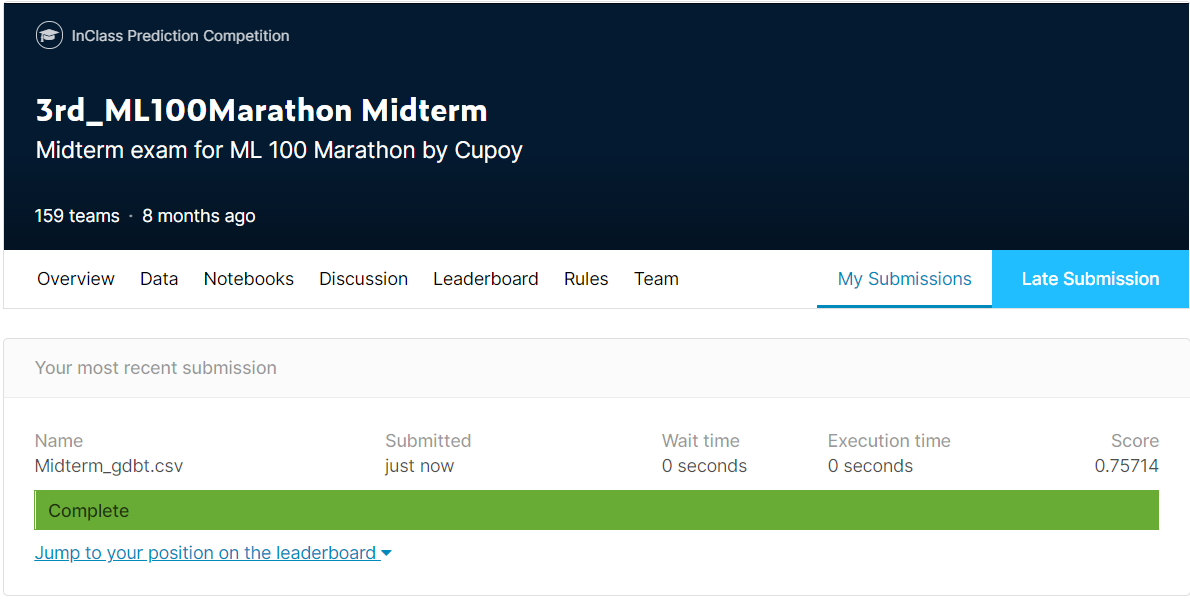